In [1]:
import os
from pathlib import Path
import logging
import numpy as np
import matplotlib.pyplot as plt
from scripts import losses
from scripts import sampling
from model_code import utils as mutils
from model_code.ema import ExponentialMovingAverage
from scripts import datasets
import torch
import wandb
from torch.utils import tensorboard
from scripts import utils
from absl import app
from absl import flags
from ml_collections.config_flags import config_flags
import matplotlib.pyplot as plt
from train import create_degrader
from scripts import sampling
from torchvision.utils import make_grid


In [2]:
workdir = "runs/no_noise"

In [3]:
# get config
from configs.mnist.blur import get_config
config = get_config()

In [4]:
# load model
# Initialize model
model = mutils.create_model(config)
optimizer = losses.get_optimizer(config, model.parameters())
ema = ExponentialMovingAverage(
    model.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=model, step=0, ema=ema)
model_evaluation_fn = mutils.get_model_fn(model, train=False, sample=True if config.model.type == 'vae' else False)

# Create checkpoints directory
checkpoint_dir = os.path.join(workdir, "checkpoints")
# Intermediate checkpoints to resume training
checkpoint_meta_dir = os.path.join(
    workdir, "checkpoints-meta", "checkpoint.pth")
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
Path(os.path.dirname(checkpoint_meta_dir)).mkdir(
    parents=True, exist_ok=True)
# Resume training when intermediate checkpoints are detected
state = utils.restore_checkpoint(checkpoint_meta_dir, state, config.device)
initial_step = int(state['step'])

# Get the forward process definition
scales = config.model.blur_schedule
degrader = create_degrader(config)

delta = config.model.delta
initial_sample = sampling.get_zero_initial_sample(config)
scales = torch.tensor(config.model.blur_schedule, device=config.device)

Creating VAE model


In [48]:
initial_sample, original_image = sampling.get_initial_sample(config, degrader, delta, config.eval.batch_size)

In [67]:
#degrade upto t=0.5
t = torch.linspace(0, 1, original_image.shape[0], device=config.device)
degraded = degrader(original_image, t)
z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
result = model_evaluation_fn(degraded, None, t, z)

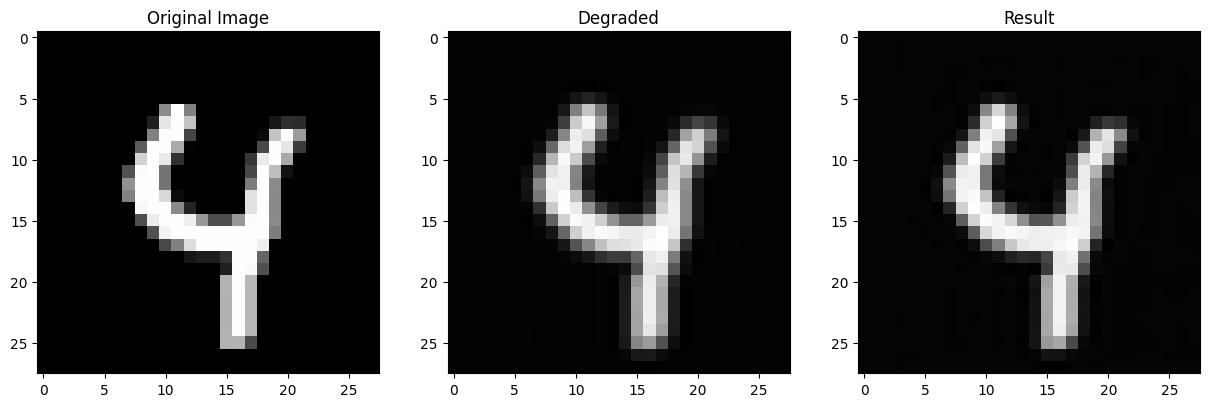

In [50]:
# plot degraded, original image, and result
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(original_image[0].cpu().detach().numpy().reshape(28, 28), cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(degraded[0].cpu().detach().numpy().reshape(28, 28), cmap='gray')
axs[1].set_title('Degraded')
axs[2].imshow(result[0].cpu().detach().numpy().reshape(28, 28), cmap='gray')
axs[2].set_title('Result')
plt.show()


In [68]:
# sampling
# while any t is not zero
x = degraded.clone()
while torch.any(t > 0):
    z = torch.randn(config.eval.batch_size, config.model.encoder.latent_dim, device=config.device)
    x[t>0] = model_evaluation_fn(x[t>0], None, t[t>0], z[t>0])
    t = t - 1/config.model.K
sampling_image = x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


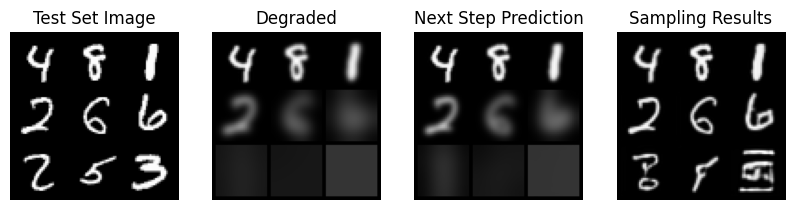

In [69]:
og_grid = make_grid(original_image, nrow=3)
degraded_grid = make_grid(degraded, nrow=3)
result_grid = make_grid(result, nrow=3)
sampling_grid = make_grid(sampling_image, nrow=3)

# Load the sampling image
sampling_image = sampling_grid

# Plot all four images
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
axs[0].imshow(og_grid.permute(1, 2, 0))
axs[0].set_title('Test Set Image')
axs[1].imshow(degraded_grid.permute(1, 2, 0))
axs[1].set_title('Degraded')
axs[2].imshow(result_grid.permute(1, 2, 0))
axs[2].set_title('Next Step Prediction')
axs[3].imshow(sampling_image.permute(1, 2, 0))
axs[3].set_title('Sampling Results')
# Hide the axis for all subplots
for ax in axs:
    ax.axis('off')
plt.show()
